In [1]:
"""
Copyright 2021 Huawei Technologies Co., Ltd

CREATED:  2022-11-23 13:12:13
MODIFIED: 2022-12-22 10:48:45
"""

# -*- coding:utf-8 -*-
import sys
sys.path.append('../../Common/acllite')
from acllite_model import AclLiteModel
from collections import defaultdict
from acllite_resource import AclLiteResource

from src.model import preprocess, DetectionEngine, get_sizes

import numpy as np
from PIL import Image, ImageDraw
import pandas as pd

In [2]:
img_path = "./data/person.jpg"
img = Image.open(img_path)

model_path = "./model/yolov5_ms.om"

acl_resource = AclLiteResource()
acl_resource.init()

model = AclLiteModel(model_path, 0)

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 408000
malloc output 1, size 1632000
malloc output 2, size 6528000
Create model output dataset success
Init model resource success


In [4]:
get_sizes(model._model_desc)

model input size 1
input  0
model input dims ({'name': 'x', 'dimCount': 4, 'dims': [1, 12, 320, 320]}, 0)
model input datatype 0
model output size 3
output  0
model output dims ({'name': 'output_0_trans_Cast_206_0', 'dimCount': 5, 'dims': [1, 20, 20, 3, 85]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'output_1_trans_Cast_207_0', 'dimCount': 5, 'dims': [1, 40, 40, 3, 85]}, 0)
model output datatype 0
output  2
model output dims ({'name': 'output_2_trans_Cast_208_0', 'dimCount': 5, 'dims': [1, 80, 80, 3, 85]}, 0)
model output datatype 0
[Model] class Model init resource stage success


(320, 320)

In [5]:
data = preprocess(img_path)
result_list = model.execute([data,])

In [6]:
img_shape = tuple(reversed(np.array(img, dtype=np.float32).shape))[1:]

detection = DetectionEngine(img_shape, 0.6)

detection.detect([result_list[0],
                  result_list[1],
                  result_list[2]],
                 1,
                 img_shape,
                 0)

detection.do_nms_for_results()

In [7]:
with open("data/coco.names") as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][1:]

df = pd.DataFrame(detection.det_boxes)
df['Classes'] = [coco_labels[i] for i in df['category_id'].values]
df.drop(['image_id'], axis = 1, inplace = True)
df.set_index('category_id').reindex(columns = ['Classes','score','bbox'])

,Classes,score,bbox
category_id,,,
0,person,0.991211,"[191.1328125, 100.099609375, 81.796875, 275.97..."
17,horse,0.992202,"[402.1875, 139.953125, 200.625, 208.6875]"
16,dog,0.984432,"[64.5703125, 264.0166015625, 141.484375, 81.88..."


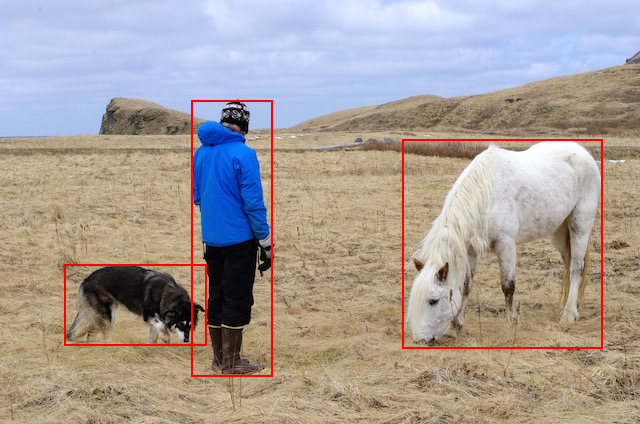

In [8]:
img_out = Image.open(img_path)
#img_out = img_out.resize(tuple(reversed(img_real.shape))[1:], 0)
img1 = ImageDraw.Draw(img_out)

for bboxes in detection.det_boxes:
    img1.rectangle([bboxes['bbox'][0],
                   bboxes['bbox'][1],
                   bboxes['bbox'][0] + bboxes['bbox'][2],
                   bboxes['bbox'][1] + bboxes['bbox'][3]],
                   outline ="red", width=2)
img_out